# Orginal data accrose 3 clacess


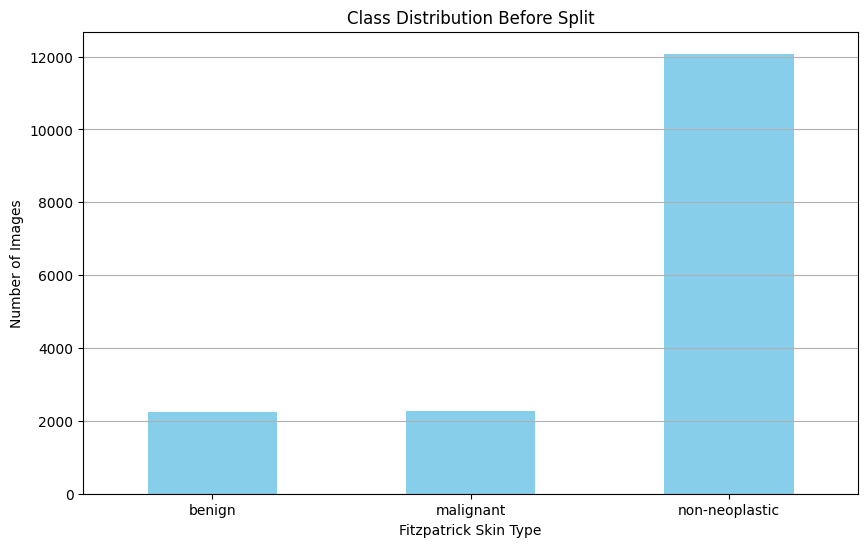

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df_cleaned = pd.read_csv('/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/fitzpatrick17k.csv')
skin_type_counts = df_cleaned['three_partition_label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
skin_type_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution Before Split')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(skin_type_counts.index)), labels=skin_type_counts.index, rotation=0)
plt.grid(axis='y')
plt.show()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_cleaned['three_partition_label'].value_counts().sort_index()

,count
three_partition_label,
benign,2234
malignant,2263
non-neoplastic,12080


# Now we load our pre processed data easily and start model train

In [4]:
import pandas as pd
import os
from zipfile import ZipFile

# Define file paths
zip_file_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/all_images_trainAug_testNonAuh_V3.zip'
unzip_dir = '/content/all_images'
metadata_csv_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/image_metadata_trainAug_testNonAuh_V3.csv'

# Unzip the images folder (run only if not already unzipped)
if not os.path.exists(unzip_dir):
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print(f"Images unzipped to {unzip_dir}")

# Load the metadata DataFrame
df_all_images = pd.read_csv(metadata_csv_path)

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train']
df_test = df_all_images[df_all_images['set'] == 'test']

# Function to load images dynamically based on class label
def get_class_data(df, class_label):
    if class_label in df['three_partition_label'].values:
        class_data = df[df['three_partition_label'] == class_label]
        X = class_data['resized_image_path'].values
        y = class_data['three_partition_label'].values
        return X, y
    else:
        print(f"Class '{class_label}' not found in DataFrame.")
        return None, None

# Example: Load image paths and labels for 'malignant' class from train set
X_train_malignant, y_train_malignant = get_class_data(df_train, 'malignant')

# Example: Load image paths and labels for 'non-neoplastic' class from test set
X_test_non_neoplastic, y_test_non_neoplastic = get_class_data(df_test, 'non-neoplastic')

# Display counts
print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Verify the loaded data
print(df_test.head())
df_train.head()

Images unzipped to /content/all_images
Train set class distribution:
three_partition_label
benign            9719
non-neoplastic    9664
malignant         9574
Name: count, dtype: int64

Test set class distribution:
three_partition_label
non-neoplastic    2416
malignant          453
benign             447
Name: count, dtype: int64
                                      resized_image_path  \
13261  /content/all_images/b6f9c924bb3b864c03ecfad295...   
13262  /content/all_images/3e96f0e6bdf82fe4ee5d7635c7...   
13263  /content/all_images/abf70b58e93e881fdad4566809...   
13264  /content/all_images/e789130a814619c1773eef8643...   
13265  /content/all_images/60c20c7458e1a508b96bd1dec2...   

      three_partition_label   set  
13261        non-neoplastic  test  
13262                benign  test  
13263                benign  test  
13264             malignant  test  
13265             malignant  test  


,resized_image_path,three_partition_label,set
0,/content/all_images/96e320998184af49bfc791c8f1...,malignant,train
1,/content/all_images/3b76144cda29793ac4bb709ab4...,non-neoplastic,train
2,/content/all_images/da81b0441ab66a8c3f55489a0d...,malignant,train
3,/content/all_images/72430e826363a44a2f9d5dd7e8...,malignant,train
4,/content/all_images/860590217a382b642fe9755f80...,non-neoplastic,train


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load your data and initialize the LabelEncoder
df_all_images = pd.read_csv(metadata_csv_path)

# Initialize LabelEncoder
label_encoder = LabelEncoder()
df_all_images['three_partition_label'] = label_encoder.fit_transform(df_all_images['three_partition_label'])

# Print the class mapping
print("Class mapping:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"{index}: {class_label}")

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train'].copy()
df_test = df_all_images[df_all_images['set'] == 'test'].copy()

print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Convert labels to string type for `class_mode='sparse'`
df_train['three_partition_label'] = df_train['three_partition_label'].astype(str)
df_test['three_partition_label'] = df_test['three_partition_label'].astype(str)

# Split df_train into training and validation sets
df_test, df_val = train_test_split(df_test, test_size=0.50, stratify=df_test['three_partition_label'], random_state=42)

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Class mapping:
0: benign
1: malignant
2: non-neoplastic
Train set class distribution:
three_partition_label
0    9719
2    9664
1    9574
Name: count, dtype: int64

Test set class distribution:
three_partition_label
2    2416
1     453
0     447
Name: count, dtype: int64
Found 28957 validated image filenames belonging to 3 classes.
Found 1658 validated image filenames belonging to 3 classes.
Found 1658 validated image filenames belonging to 3 classes.


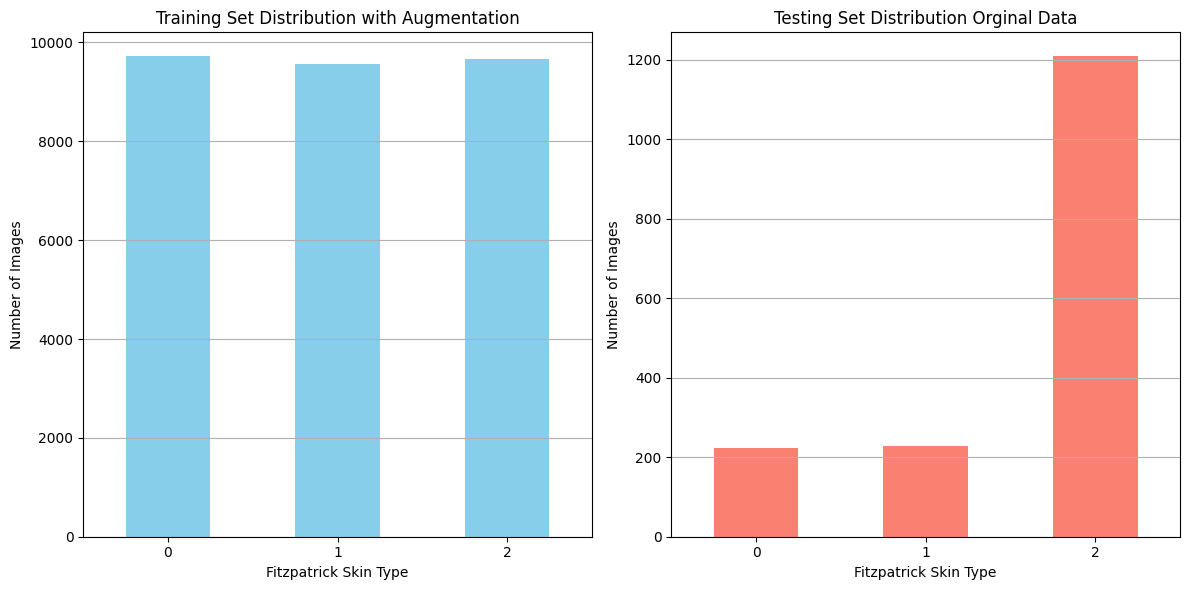

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

train_skin_type_counts = df_train['three_partition_label'].value_counts().sort_index()
test_skin_type_counts = df_test['three_partition_label'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_skin_type_counts.plot(kind='bar', color='skyblue')
plt.title('Training Set Distribution with Augmentation')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(train_skin_type_counts.index)), labels=train_skin_type_counts.index, rotation=0)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
test_skin_type_counts.plot(kind='bar', color='salmon')
plt.title('Testing Set Distribution Orginal Data')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(test_skin_type_counts.index)), labels=test_skin_type_counts.index, rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


# See Last 20 train Image to be sure all goes well

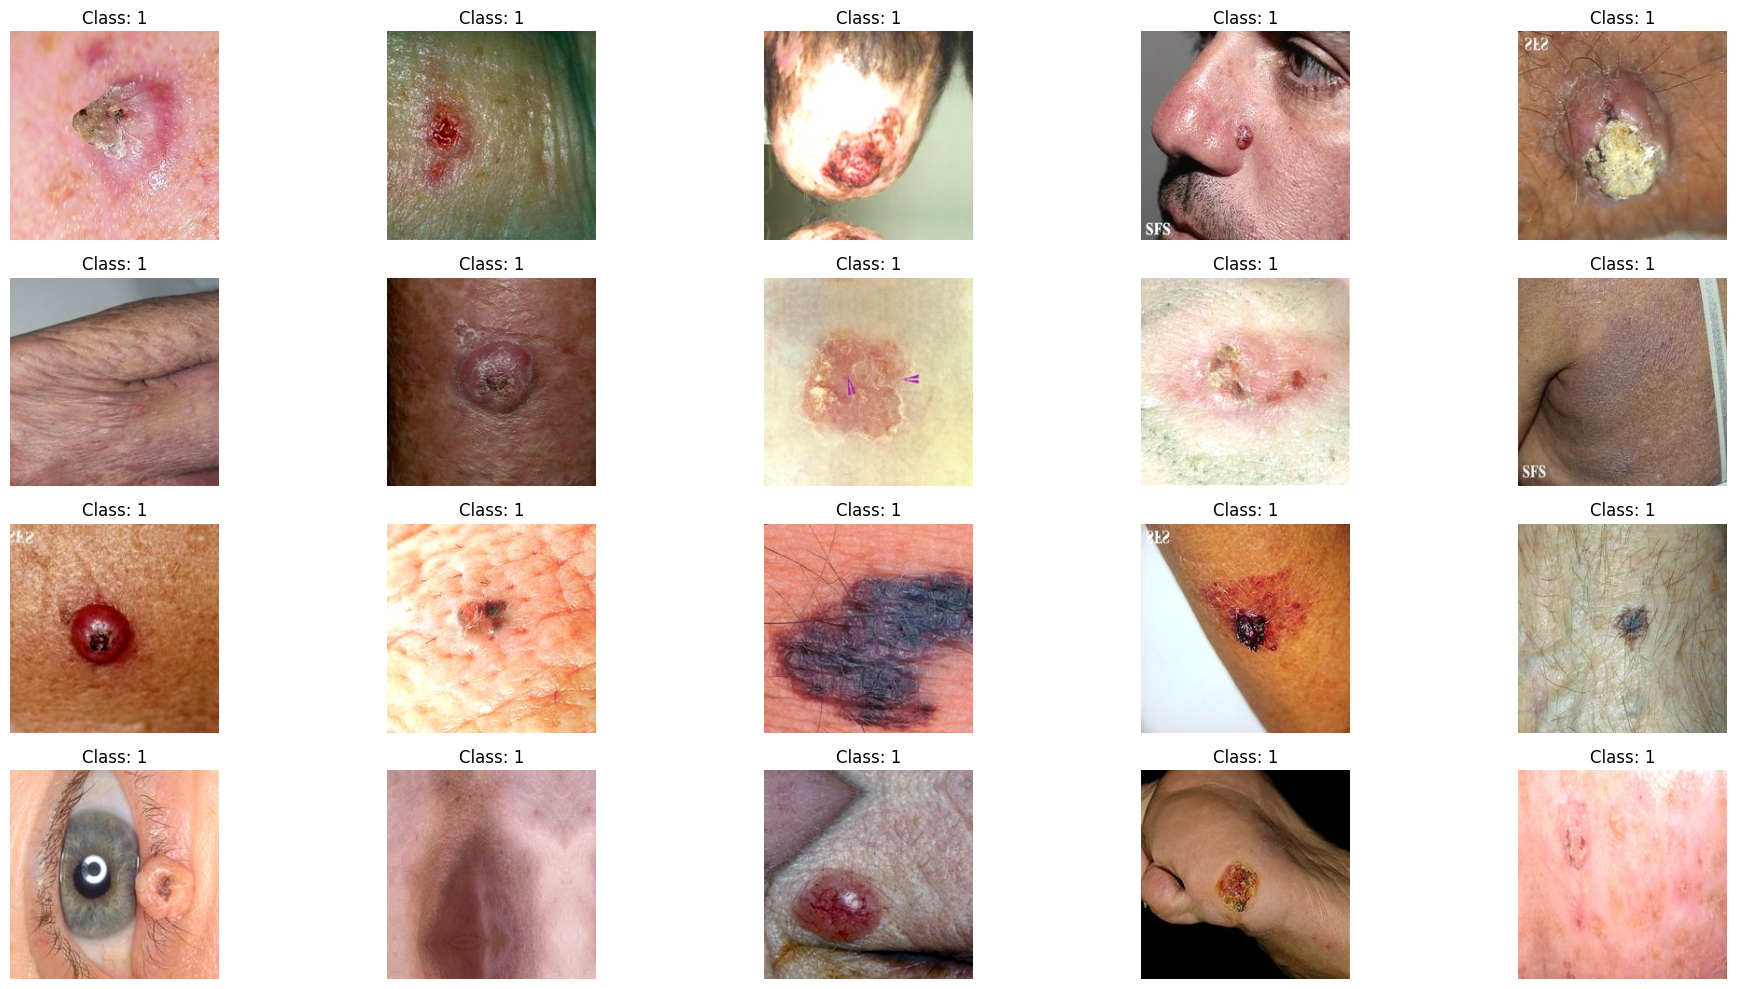

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Display the first 20 augmented images
sample = df_train.tail(20)

plt.figure(figsize=(20, 10))

for i, row in enumerate(sample.itertuples(), start=1):
    image_path = row.resized_image_path
    image = Image.open(image_path)

    plt.subplot(4, 5, i)
    plt.imshow(image)
    plt.title(f"Class: {row.three_partition_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Start Model creation and training




# NASNetLarge

In [10]:
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau

csv_logger = CSVLogger('nasnetlarge_training_log.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# Custom Class Weights
# custom_class_weights = {
#     0: 2.0,
#     1: 3.0,
#     2: 1.0
# }

# Load NASNetLarge
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    # class_weight=custom_class_weights,
    callbacks=[csv_logger, early_stopping, reduce_lr]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'NASNetLarge Test accuracy: {test_accuracy:.4f}')


Epoch 1/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 359s 356ms/step - accuracy: 0.3889 - loss: 1.4608 - val_accuracy: 0.5434 - val_loss: 1.0536 - learning_rate: 1.0000e-04
Epoch 2/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 287s 317ms/step - accuracy: 0.4380 - loss: 1.0594 - val_accuracy: 0.4789 - val_loss: 1.0770 - learning_rate: 1.0000e-04
Epoch 3/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 288s 317ms/step - accuracy: 0.4491 - loss: 1.0451 - val_accuracy: 0.5030 - val_loss: 1.0513 - learning_rate: 1.0000e-04
Epoch 4/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 287s 317ms/step - accuracy: 0.4522 - loss: 1.0413 - val_accuracy: 0.5422 - val_loss: 1.0554 - learning_rate: 1.0000e-04
Epoch 5/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 287s 317ms/step - accuracy: 0.4637 - loss: 1.0298 - val_accuracy: 0.5549 - val_loss: 1.0120 - learning_rate: 1.0000e-04
Epoch 6/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 287s 317ms/step - accuracy: 0.4604 - loss: 1.0277 - val_accuracy: 0.6128 - val_loss: 0.9505 - learning_rate: 1.0000e-04
Epoch 7/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/EfficientNetB0_L2_18_Sept_2024_V3.h5')

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 297ms/step - accuracy: 0.6195 - loss: 0.9357
Test accuracy: 61.70%


52/52 ━━━━━━━━━━━━━━━━━━━━ 45s 588ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.20      0.21       223
           1       0.27      0.36      0.30       227
           2       0.78      0.74      0.76      1208

    accuracy                           0.62      1658
   macro avg       0.42      0.43      0.43      1658
weighted avg       0.63      0.62      0.62      1658



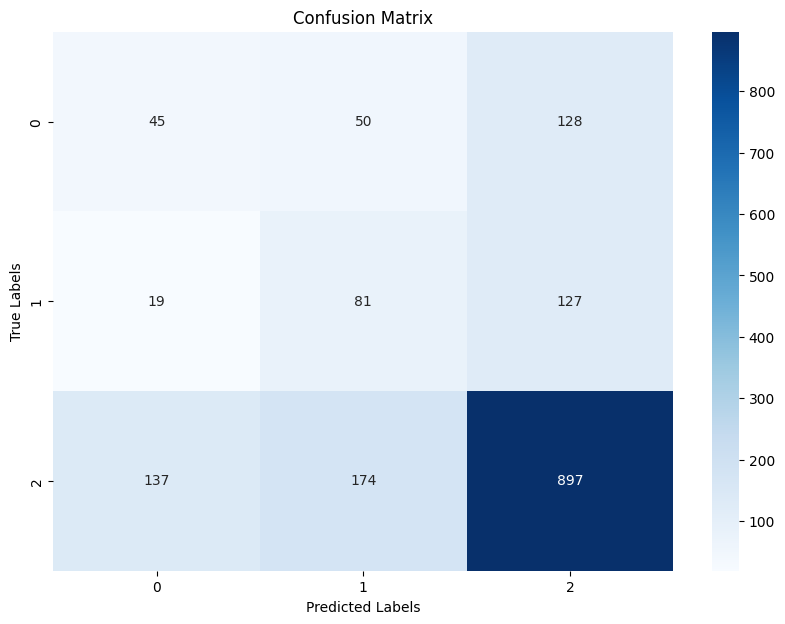

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `model` is your trained model and `test_generator` is your data generator
# Make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




In [13]:
import os

# Define the path where you want to save the model
model_save_path = '/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V3/NASNetLarge/NASNetLarge_L3_19_Sept_2024_V3.h5'

# Save the model
model.save(model_save_path)

print(f"Model saved at {model_save_path}")

Model saved at /content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V3/NASNetLarge/NASNetLarge_L3_19_Sept_2024_V3.h5


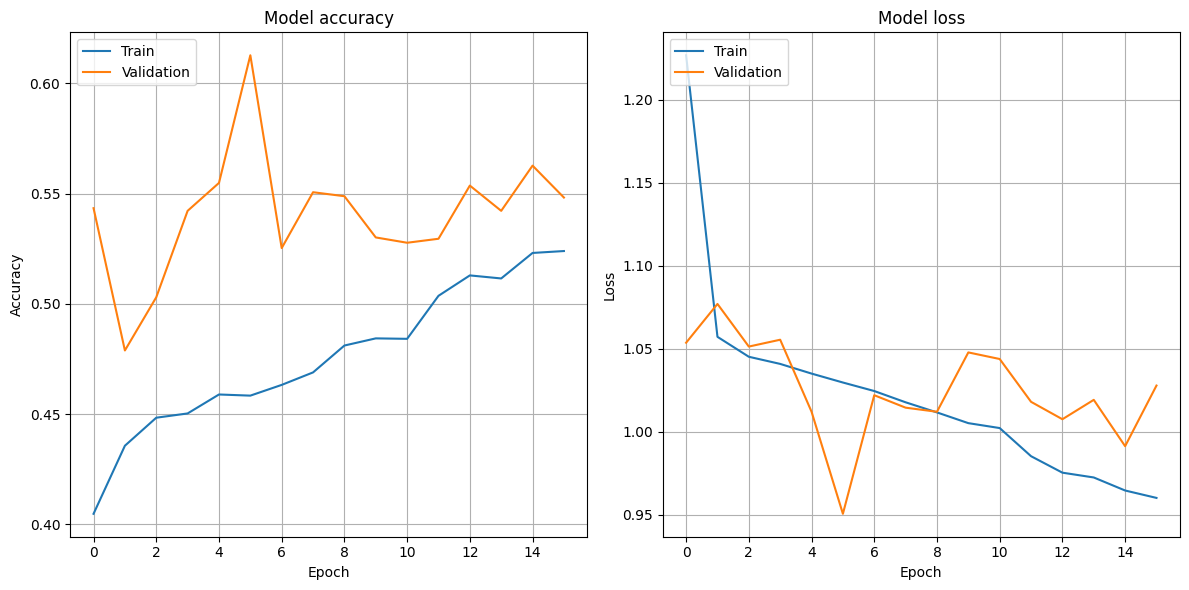

In [14]:
# prompt: generate history chart

import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()
